<h1>Chord Representations</h1>
<br>
In this Notebook we are going to explore a different representation for the chords
<br>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio_processing/')
sys.path.append('./src/data_processing/')
sys.path.append('./src/chord_parser/')
sys.path.append('./src/metrics/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

## CQT
- number of bins = 192
- bins per octave = 24
- sample rate = 22050 Hz
- min frequency = C1 (~31Hz)
- hop_length = 2048

In [85]:
nbins=192
bins_per_octave=24
hop_length=2048
audiofiles_path = 'Audiofiles/The Beatles'

Spectrograms = {'The Beatles': {}}
Timestamps = {'The Beatles': {}}

In [87]:
## cqt on isophonics
for filename in Path(audiofiles_path).glob('**/*.wav'):

    path, track = os.path.split(filename)
    path, album = os.path.split(path)

    track_no = re.search('([0-9].).', track).group(1)

    # read wav and create spectrogram
    track, sample_rate = librosa.load(filename, sr = 22050)
    track_time = librosa.get_duration(y=track, sr=sample_rate)
#     n_fft = int(track_time // (hop_length / sample_rate))
    
    spectrogram = librosa.cqt(track, sr=sample_rate, n_bins=nbins, bins_per_octave=bins_per_octave, hop_length=hop_length)

    frames = list(range(0, spectrogram.shape[1]))
    times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

    if album not in Spectrograms['The Beatles']:
        Spectrograms['The Beatles'][album] = {}
        Timestamps['The Beatles'][album] = {}

    Spectrograms['The Beatles'][album][track_no] = librosa.amplitude_to_db(abs(spectrogram), ref=np.max).T
    Timestamps['The Beatles'][album][track_no] = times

In [88]:
input_features = nbins
Timeseries = Spectrograms
Artist = 'The Beatles'
# Scale Spectrogram Data
for album in Timeseries[Artist].keys():
    for track_no in Timeseries[Artist][album]:
        Timeseries[Artist][album][track_no] += 80

Skip this step for billboard

In [34]:
### cqt on billboard
Timeseries_Billboard = {}
Timestamps_Billboard = {}
for filename in Path('Billboard-Dataset/billboard-2.0-chordino/McGill-Billboard/').glob('**/bothchroma.csv'):

    path, _ = os.path.split(filename)
    path, track = os.path.split(path)
    
    chroma = pd.read_csv(filename, sep=',', header=None).drop([0], axis = 1)
    Timeseries_Billboard[track] = librosa.amplitude_to_db(np.asarray(chroma.iloc[:,1:], dtype="float32"), ref=np.max)
    Timestamps_Billboard[track] = np.asarray(chroma.iloc[:,0])

In [35]:
# Scale Spectrogram Data
for track_no in Timeseries_Billboard.keys():
    Timeseries_Billboard[track_no] += 80

Only if in possesion of billboard **GLOBAL z-normalization**

In [36]:
global_Scaler = StandardScaler()

for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            global_Scaler.fit(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    global_Scaler.fit(track_data)
            
for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            Timeseries[artist][album][track_no] = global_Scaler.transform(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    Timeseries_Billboard[track_no] = global_Scaler.transform(track_data)

<h3>Loading Datasets</h3>

#### Isophonics

In [89]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

#### McGill Billboard

In [10]:
### get all chordlab files
Chordlab_Billboard = {}
for filename in Path('Billboard-Dataset/billboard-2.0.1-mirex/McGill-Billboard/').glob('**/majmin7.lab'):
    
    path, _ = os.path.split(filename)
    path, track = os.path.split(path)
        
    Chordlab_Billboard[track] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep='\t', header=None)
    chordlist = []
    for index, row in Chordlab_Billboard[track].iterrows():
        #in billboard dataset, A is A:maj
        chord = row['Chord']
        if row['Chord'].find(':') != -1:
            root, mode = row['Chord'].split(':')
            if mode == 'maj':
                chord = root
                
        chordlist.append(chord)
        
    chordlist = pd.Series(chordlist, name='Chord', index=list(range(0, len(chordlist))))
    Chordlab_Billboard[track].update(chordlist)

<h3>Chord Vocab</h3>

In [90]:
### Load all chords in a dictionary
Chords = []
Appearances = {}
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: 
                Chords.append(row['Chord'])
                Appearances[row['Chord']] = 0
            else: 
                Appearances[row['Chord']] += 1
            
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  816


In [ ]:
#billboard
for track_no in Chordlab_Billboard.keys():
    for index, row in Chordlab_Billboard[track_no].iterrows():
        if row['Chord'] not in Chords: 
            Chords.append(row['Chord'])
            Appearances[row['Chord']] = 0
        else: 
            Appearances[row['Chord']] += 1 

In [92]:
Major_Chords = 0
Minor_Chords = 0

for chord in Chords:
    if chord.find('min') != -1:
        Minor_Chords += Appearances[chord]
    else:
        Major_Chords += Appearances[chord]
        
print ('Major Chords: ', Major_Chords, '\nMinor Chords: ', Minor_Chords)

Major Chords:  34392 
Minor Chords:  8655


Major Chords = 4*Minor Chords -> 
1. We need to increment the number of minor chords
2. Or we can punish harder for the predictions on minor chords

## Dataset Annotations Transformation

<img src="images/label_representation.png" width="400" />

<caption><center> <b>Figure 1</b>: Labeling Representation.</center></caption>

In [77]:
ChordLib = {'C' : 0, 'C#': 1, 'Db' : 1, 'D' : 2, 'D#' : 3, 'Eb' : 3, 'E' : 4, 'Fb' : 4, 'F' : 5, 'F#' : 6, 'Gb' : 6, 'G' : 7, 'G#' : 8, 'Ab' : 8, 'A' : 9, 'A#' : 10, 'Bb' : 10, 'B' : 11, 'Cb' : 11, 'N' : 12, 'X' : 13}

<img src="images/intervals.png" width="400" />

<caption><center> <b>Figure 2</b>: Semitones to Intervals.</center></caption>

In [78]:
def Semitonize(interval, mode):
    if interval == '0':
        return 0
    
    if mode == 'Major':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '6':
            return 9
        elif interval == 'b6':
            return 8
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        if interval == '9':
            return 13
        else:
            return 0
    elif mode == 'Minor':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
    elif mode == 'Dim':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        else:
            return 0
    elif mode == 'Aug':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        else:
            return 0
    else:
        return 0

In [93]:
def parse_chords(Chords, df):
    # silence
    df['Root'].append(ChordLib['N'])
    df['Unknown'].append(0)
    df['Major'].append(0)
    df['Minor'].append(0)
    df['Diminished'].append(0)
    df['Augmented'].append(0)
    df['Seventh'].append(0)
    df['Major Seventh'].append(0)
    df['Minor Seventh'].append(0)
    df['Major Sixth'].append(0)
    df['Fifth'].append(0)
    # for all chords in vocab
    for chord in Chords:
        if chord == 'N':
            continue
        # print('* Chord: ', chord)
        Mode = 'Major'
        fourth_note = ''
        fourth_note_mode = ''
        Unknown = False
        # discard inversion if exists
        if chord.find('/') != -1:
            chord, _ = chord.split('/')
        
        if chord == 'X':
            root = chord
            Unknown = True
            
        if chord.find(':') != -1:
            root, chord = chord.split(':')
            if chord[:3] == 'min':
                Mode = 'Minor'
                if chord != 'min':
                    if chord[3] == '7':
                        fourth_note = '7'
                        fourth_note_mode = 'minor'
                    if chord[3] == '(':
                        Unknown = True
            elif chord[:3] == 'dim':
                Mode = 'Dim'
                if chord != 'dim':
                    fourth_note = chord[3]
                    fourth_note_mode = 'dominant'
            elif chord[:3] == 'aug':
                Mode = 'Aug'
                if chord != 'aug':
                    fourth_note = chord[3]
                    fourth_note_mode = 'major'
            elif chord[:3] == 'maj':
                Mode = 'Major'
                fourth_note_mode = 'major'
                if chord != 'maj':
                    chord = chord[3:]
                    fourth_note = chord[0]
                    if fourth_note == '(':
                        Unknown = True
            elif chord[:4] == 'sus2':
                Mode = 'Sus2'
                Unknown = True
            elif chord[:4] == 'sus4':
                Mode = 'Sus4'
                Unknown = True
            elif chord[:4] == 'sus7':
                Mode = 'Sus4'
                fourth_note = '7'
                fourth_note_mode = 'dominant'
                Unknown = True
            elif chord[:4] == 'sus9':
                Mode = 'Sus4'
                fourth_note = '7'
                fourth_note_mode = 'dominant'
                Unknown = True
            elif chord[:4] == 'hdim':
                #half diminished
                Mode ='Dim'
                fourth_note_mode = 'minor'
                fourth_note = chord[4]
            else:
                Mode = 'Major'
                #Dominant seventh
                fourth_note = chord[0]
                fourth_note_mode = 'dominant'
                if fourth_note == '(':
                    Unknown = True
        else:
            root = chord

        if not Unknown:
            #print(root, bass, Mode, fourth_note)
            df['Root'].append(ChordLib[root])        
            df['Unknown'].append(0)
            df['Major'].append(int(Mode == 'Major' or Mode == 'Aug'))
            df['Minor'].append(int(Mode == 'Minor' or Mode == 'Dim'))
            df['Diminished'].append(int(Mode == 'Dim'))
            df['Augmented'].append(int(Mode == 'Aug'))
            df['Seventh'].append(int(fourth_note == '7' and fourth_note_mode == 'dominant'))
            df['Major Seventh'].append(int((fourth_note == '7' or fourth_note == '9') and fourth_note_mode == 'major'))
            df['Minor Seventh'].append(int((fourth_note == '7' or fourth_note == '9') and fourth_note_mode == 'minor'))
            df['Major Sixth'].append(int(fourth_note == '6'))
            df['Fifth'].append(int(Mode == 'Minor' or Mode == 'Major'))
        else:
            #print ('Unknown')
            df['Root'].append(ChordLib[root])
            df['Unknown'].append(1)
            df['Major'].append(0)
            df['Minor'].append(0)
            df['Diminished'].append(0)
            df['Augmented'].append(0)
            df['Seventh'].append(0)
            df['Major Seventh'].append(0)
            df['Minor Seventh'].append(0)
            df['Major Sixth'].append(0)
            df['Fifth'].append(0)
        #print('-----')

In [94]:
df = pd.DataFrame(columns=('Root', 'Unknown', 'Major', 'Minor', 'Seventh', 'Minor Seventh', 'Major Seventh', 'Augmented', 'Diminished', 'Fifth', 'Major Sixth'))
representations = {'Root' : [], 'Unknown' : [], 'Major' : [], 'Minor' : [], 'Seventh' : [], 'Minor Seventh' : [], 'Major Seventh' : [], 'Augmented' : [], 'Diminished' : [], 'Fifth' : [], 'Major Sixth' : []}

In [95]:
parse_chords(Chords, representations)

**Convert the dictionary to dataframe**

In [96]:
df = pd.DataFrame(data=representations, index=Chords).rename_axis('Chord', axis = 1)
df.iloc[400:]

Chord,Root,Unknown,Major,Minor,Seventh,Minor Seventh,Major Seventh,Augmented,Diminished,Fifth,Major Sixth
Eb:min7,3,0,0,1,0,1,0,0,0,1,0
"Gb:min7(*5,b6)",6,0,0,1,0,1,0,0,0,1,0
Gb:7(#9),6,0,1,0,1,0,0,0,0,1,0
Gb:min(*5),6,1,0,0,0,0,0,0,0,0,0
Ab:sus4,8,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
C#:min/4,1,0,0,1,0,0,0,0,0,1,0
G:maj6(9),7,0,1,0,0,0,0,0,0,1,1
G:dim7,7,0,0,1,1,0,0,0,1,0,0
B:aug/3,11,0,1,0,0,0,0,1,0,0,0


Now this is a dictionary for every chord<br>
I'm going to index every chord with its timestep just liek before, but instead of a one hot of size 407, we will have the above representation<br>

## Preprocessing

In [97]:
encoder = OneHotEncoder(categories='auto')
encoder.fit(np.array(list(range(0,14))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [98]:
### Annotations
Artist='The Beatles'
root_vec = {}
quality_vec = {}
for album in Chordlab[Artist].keys():
    root_vec[album] = {}
    quality_vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        root = np.empty((14,))
        quality = np.empty((10,))
        row = next(df_rows)
        for timestamp in Timestamps[Artist][album][track_no]:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            root = np.column_stack((root, encoder.transform([[df.loc[row[3]]['Root']]]).toarray()[0]))
            quality = np.column_stack((quality, np.array(df.loc[row[3]][1:])))
        root_vec[album][track_no] = root
        quality_vec[album][track_no] = quality
    print(album, ' completed')

10CD2_-_The_Beatles_up3  completed
07_-_Revolver_up3  completed
04_-_Beatles_for_Sale_up3  completed
11_-_Abbey_Road_up3  completed
02_-_With_the_Beatles_up3  completed
12_-_Let_It_Be_up3  completed
05_-_Help!_up3  completed
03_-_A_Hard_Day's_Night_up3  completed
09_-_Magical_Mystery_Tour_up3  completed
08_-_Sgt._Pepper's_Lonely_Hearts_Club_Band_up3  completed
01_-_Please_Please_Me_up3  completed
10CD1_-_The_Beatles_up3  completed
06_-_Rubber_Soul_up3  completed
06_-_Rubber_Soul_down3  completed
09_-_Magical_Mystery_Tour_down3  completed
12_-_Let_It_Be_down3  completed
10CD1_-_The_Beatles_down3  completed
05_-_Help!_down3  completed
04_-_Beatles_for_Sale_down3  completed
03_-_A_Hard_Day's_Night_down3  completed
07_-_Revolver_down3  completed
10CD2_-_The_Beatles_down3  completed
08_-_Sgt._Pepper's_Lonely_Hearts_Club_Band_down3  completed
02_-_With_the_Beatles_down3  completed
01_-_Please_Please_Me_down3  completed
11_-_Abbey_Road_down3  completed
09_-_Magical_Mystery_Tour  completed
12_

In [99]:
# Take care fo the one extra row in the beginning of the array
for album in root_vec.keys():
    for track_no in root_vec[album].keys():
        root_vec[album][track_no] = np.delete(root_vec[album][track_no], 0, 1)
        quality_vec[album][track_no] = np.delete(quality_vec[album][track_no], 0, 1)

In [ ]:
# Billboard
album = 'Billboard1000'
root_vec[album] = {}
quality_vec[album] = {}
for track_no in Chordlab_Billboard.keys():
    df_rows = Chordlab_Billboard[track_no].itertuples()
    index = 0
    max_len = len(Chordlab_Billboard[track_no])
    root = np.empty((14,))
    quality = np.empty((10,))
    row = next(df_rows)
    for timestamp in Timestamps_Billboard[track_no]:
        if ((index + 1) < max_len) & (timestamp >= row[2]):
            index += 1
            row = next(df_rows)
        root = np.column_stack((root, encoder.transform([[df.loc[row[3]]['Root']]]).toarray()[0]))
        quality = np.column_stack((quality, np.array(df.loc[row[3]][1:])))
    root_vec[album][track_no] = root
    quality_vec[album][track_no] = quality
print(album, ' completed')

In [100]:
### STORE
import pickle

with open('root_vec.pickle', 'wb') as handle:
    pickle.dump(root_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('quality_vec.pickle', 'wb') as handle:
    pickle.dump(quality_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
### LOAD
import pickle

with open('root_vec.pickle', 'rb') as handle:
    root_vec = pickle.load(handle)
    
with open('quality_vec.pickle', 'rb') as handle:
    quality_vec = pickle.load(handle)

#### Constructing numpy arrays
chunk_size = slicing window (~10 secs)
<br>
input_features = nbins

In [102]:
chunk_size = 200

In [103]:
# train set
x_train = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_train_root = np.zeros((1,chunk_size,14))
# test set
x_test = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_test_root = np.zeros((1,chunk_size,14))
# validation set
x_val = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_val_root = np.zeros((1,chunk_size,14))

# test track
test_track_no = '02'
album_test_track = '07_-_Revolver'
# validation album
album_validate = '10CD1_-_The_Beatles'

for album in root_vec.keys():
    if album.find(album_validate) != -1:
        continue
    for track_no in root_vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = root_vec[album][track_no].T.shape[0]
        # track frequencies
        timeseries = Timeseries['The Beatles'][album][track_no]
        # track annotations
        annotations = root_vec[album][track_no].T
        # slice and stack train-test data
        if track_no != test_track_no or album != album_test_track:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
                    x_train = np.append(x_train, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                    y_train_root = np.append(y_train_root, batch_y, axis = 0)
                else:
                    batch_x = timeseries[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                        batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                    x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                    y_train_root = np.append(y_train_root, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
                    x_test = np.append(x_test, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                    y_test_root = np.append(y_test_root, batch_y, axis = 0)
                else:
                    batch_x = timeseries[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                        batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                    x_test = np.append(x_test, np.array([batch_x]), axis = 0)
                    y_test_root = np.append(y_test_root, np.array([batch_y]), axis = 0)
                # augment timesteps
                timestep += chunk_size

print (x_train.shape, y_train_root.shape, x_test.shape, y_test_root.shape)

(4494, 200, 192) (4494, 200, 14) (8, 200, 192) (8, 200, 14)


In [104]:
# validation set
x_val = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_val_root = np.zeros((1,chunk_size,14))

for track_no in root_vec[album_validate].keys():
    timestep = 0
    # size of the current track
    chunks = root_vec[album_validate][track_no].T.shape[0]
    # track frequencies
    timeseries = Timeseries['The Beatles'][album_validate][track_no]
    # track annotations
    annotations = root_vec[album_validate][track_no].T
    # validation tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
            x_val = np.append(x_val, batch_x, axis = 0)
            batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_val_root = np.append(y_val_root, batch_y, axis = 0)
        else:
            batch_x = timeseries[timestep:,:]
            batch_y = annotations[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
            x_val = np.append(x_val, np.array([batch_x]), axis = 0)
            y_val_root = np.append(y_val_root, np.array([batch_y]), axis = 0)
        # augment timesteps
        timestep += chunk_size

print (x_val.shape, y_val_root.shape)

(159, 200, 192) (159, 200, 14)


**annotations quality**

In [105]:
y_train_quality = np.zeros((1,chunk_size,10))
y_test_quality = np.zeros((1,chunk_size,10))
y_val_quality = np.zeros((1,chunk_size,10))

for album in root_vec.keys():
    if album.find(album_validate) != -1:
        continue
    for track_no in root_vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = quality_vec[album][track_no].T.shape[0]
        # track frequencies
        timeseries = Timeseries['The Beatles'][album][track_no]
        # track annotations
        annotations_quality = quality_vec[album][track_no].T
        # slice and stack train-test data
        if track_no != test_track_no or album != album_test_track:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 10))
                    y_train_quality = np.append(y_train_quality, batch_y, axis = 0)
                else:
                    batch_y = annotations_quality[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_y = np.vstack((batch_y, df.loc['N'][1:]))
                    y_train_quality = np.append(y_train_quality, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 10))
                    y_test_quality = np.append(y_test_quality, batch_y, axis = 0)
                else: 
                    batch_y = annotations_quality[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_y = np.vstack((batch_y, df.loc['N'][1:]))
                    y_test_quality = np.append(y_test_quality, np.array([batch_y]), axis = 0)
                timestep += chunk_size

print (y_train_quality.shape, y_test_quality.shape)

(4494, 200, 10) (8, 200, 10)


In [106]:
for track_no in root_vec[album_validate].keys():
    timestep = 0
    # size of the current track
    chunks = quality_vec[album_validate][track_no].T.shape[0]
    # track frequencies
    timeseries = Timeseries['The Beatles'][album_validate][track_no]
    # track annotations
    annotations_quality = quality_vec[album_validate][track_no].T
    # train tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 10))
            y_val_quality = np.append(y_val_quality, batch_y, axis = 0)
        else:
            batch_y = annotations_quality[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_y = np.vstack((batch_y, df.loc['N'][1:]))
            y_val_quality = np.append(y_val_quality, np.array([batch_y]), axis = 0)
        timestep += chunk_size
        
print (y_val_quality.shape)

(159, 200, 10)


Delete the first row from every array because of the append, which left it all zeros.

In [107]:
x_train = np.delete(x_train,0,0)
x_test = np.delete(x_test,0,0)
x_val = np.delete(x_val,0,0)

y_train_root = np.delete(y_train_root,0,0)
y_test_root = np.delete(y_test_root,0,0)
y_val_root = np.delete(y_val_root,0,0)

y_train_quality = np.delete(y_train_quality,0,0)
y_test_quality = np.delete(y_test_quality,0,0)
y_val_quality = np.delete(y_val_quality,0,0)

## Neural Network

In [108]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

#### BLSTM_2Layer

In [109]:
def BLSTM_2Layer(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64, 
                           batch_input_shape = (batch_size, timesteps, input_features),
                           kernel_initializer = 'glorot_uniform',
                           activation='tanh',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences = True))(main_input)
    x = Dropout(0.4)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           activation='tanh',
                           recurrent_regularizer='l2',
                           return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128)(x)
    x = Activation('sigmoid')(x)
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [110]:
def Qualities_BLSTM_2Layer(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features), name='main_input')
    
    x = Dropout(0.2)(main_input)
    x = Dense(100)(x)
    #BLSTM
    x = Bidirectional(LSTM(units = 50, activation='tanh', return_sequences = True))(x)
    
    x = Dropout(0.4)(x)
    #BLSTM
    x = Bidirectional(LSTM(units = 50, activation='tanh', return_sequences=True))(x)
    
    x = Dropout(0.4)(x)
    
    #Dense for classification
    g = TimeDistributed(Dense(2))(x)
    triad = Activation('softmax')(g)

    d = TimeDistributed(Dense(3))(x)
    seventh = Activation('sigmoid')(d)

    f = TimeDistributed(Dense(3))(x)
    fifth = Activation('softmax')(f)
    
    s = TimeDistributed(Dense(1))(x)
    sixth = Activation('sigmoid')(s)

    u = TimeDistributed(Dense(1))(x)
    unknown = Activation('sigmoid')(u)
    
    # concatenation
    main_output = concatenate([unknown,triad,seventh,fifth,sixth], axis=-1)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [402]:
def Hybrid(chords_num, input_features, timesteps, batch_size, output_activation):
    
    if output_activation not in ['sigmoid', 'softmax', 'relu']:
        print ('Error: Unknown Activation Function')
        return
    
    main_input = Input(shape=(timesteps,input_features,1), name='main_input')
    
    #Convolutional Stack 1
    c =  TimeDistributed(Conv1D(filters=16, 
               kernel_size=3,
               padding='same'))(main_input)
    
    c =  TimeDistributed(Conv1D(filters=16, 
               kernel_size=3,
               padding='same'))(c)
    
    c =  TimeDistributed(Conv1D(filters=16, 
               kernel_size=3,
               padding='same'))(c)
    
    c = Dropout(0.25)(c)
    c = Activation('relu')(c)
    
    #Convolutional Stack 2
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3,
               padding='same'))(c)
    
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3,
               padding='same'))(c)
    
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3,
               padding='same'))(c)
    
    c = Dropout(0.25)(c)
    
    c = TimeDistributed(MaxPooling1D(2,2))(c)
    c = Activation('relu')(c)
    
    #Convolutional Stack 3
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=3,
               padding='same'))(c)
    
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=3,
               padding='same'))(c)
    
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=3,
               padding='same'))(c)
    
    c = Dropout(0.25)(c)
    
    c = TimeDistributed(MaxPooling1D(2,2))(c)
    c = Activation('relu')(c)
    
    x = TimeDistributed(Flatten())(c)
    
    x = BatchNormalization()(x)
    
    x = Dense(128)(x)
    x = Activation('relu')(x)
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64,
                           return_sequences=True))(x)
    
    x = Bidirectional(LSTM(units = 64,
                           return_sequences=True))(x)
    
    x = Dropout(0.25)(x)
    
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation(output_activation)(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

#### Summary

In [111]:
batch_size = 15

In [112]:
# Construct Models

root_model = BLSTM_2Layer(14, input_features, chunk_size, batch_size)
quality_model = Qualities_BLSTM_2Layer(10, input_features, chunk_size, batch_size)

In [113]:
# Compile Models

root_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

quality_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.binary_crossentropy,
              sample_weight_mode="temporal",
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

root_model.summary()
quality_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 200, 192)]        0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 128)          131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200, 128)          98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
dense_8 (Dense)              (None, 200, 128)          16512     
_________________________________________________________________
activation_7 (Activation)    (None, 200, 128)          0   

In [50]:
# to use the hybrid model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))

In [51]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))

**Fit**

In [123]:
epochs = 20

# train
callback_history_root = root_model.fit(x_train, y_train_root, epochs=epochs,
          validation_data=(x_val, y_val_root), batch_size=batch_size, verbose=1)

Train on 4493 samples, validate on 158 samples
Epoch 1/20
4493/4493 [==============================] - 24s 5ms/sample - loss: 1.2100 - accuracy: 0.6281 - precision_2: 0.7771 - recall_2: 0.4962 - val_loss: 1.3868 - val_accuracy: 0.6070 - val_precision_2: 0.7328 - val_recall_2: 0.5333
Epoch 2/20
4493/4493 [==============================] - 23s 5ms/sample - loss: 1.1680 - accuracy: 0.6407 - precision_2: 0.7844 - recall_2: 0.5119 - val_loss: 1.3897 - val_accuracy: 0.6007 - val_precision_2: 0.7341 - val_recall_2: 0.5003
Epoch 3/20
4493/4493 [==============================] - 23s 5ms/sample - loss: 1.1916 - accuracy: 0.6325 - precision_2: 0.7771 - recall_2: 0.5024 - val_loss: 1.5430 - val_accuracy: 0.5751 - val_precision_2: 0.7104 - val_recall_2: 0.4829
Epoch 4/20
4493/4493 [==============================] - 23s 5ms/sample - loss: 1.1669 - accuracy: 0.6410 - precision_2: 0.7836 - recall_2: 0.5128 - val_loss: 1.3494 - val_accuracy: 0.6238 - val_precision_2: 0.7307 - val_recall_2: 0.5515
Epoch

In [129]:
# evaluate on test set
loss, accuracy, precision, recall = root_model.evaluate(x_test, y_test_root, batch_size=batch_size, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%" %(loss, 100*accuracy))

Loss: 		 1.213 
Accuracy: 	 74.50 %


In [183]:
weights = np.ones((x_train.shape[0], x_train.shape[1]))
# find the appropriate weights for the minority classes
i = 0
j = 0
for chunk in y_train_quality:
    for label in chunk:
        if label[2] == 1:
            weights[i][j] = 3
        if label[3] == 1:
            weights[i][j] += 3
        j += 1
    i += 1
    j = 0

print (weights)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 4. 4. 4.]
 [4. 4. 4. ... 1. 1. 4.]
 [4. 4. 4. ... 1. 1. 1.]]


In [184]:
epochs = 10

# train
callback_history_quality = quality_model.fit(x_train, y_train_quality, epochs=epochs,
          validation_data=(x_val, y_val_quality), batch_size=batch_size, verbose=1, sample_weight=weights)

Train on 4493 samples, validate on 158 samples
Epoch 1/10
4493/4493 [==============================] - 29s 6ms/sample - loss: 0.4309 - accuracy: 0.9126 - precision_7: 0.7607 - recall_7: 0.7874 - val_loss: 0.2450 - val_accuracy: 0.8999 - val_precision_7: 0.7619 - val_recall_7: 0.7335
Epoch 2/10
4493/4493 [==============================] - 26s 6ms/sample - loss: 0.4318 - accuracy: 0.9135 - precision_7: 0.7634 - recall_7: 0.7889 - val_loss: 0.2507 - val_accuracy: 0.8976 - val_precision_7: 0.7554 - val_recall_7: 0.7290
Epoch 3/10
4493/4493 [==============================] - 26s 6ms/sample - loss: 0.4290 - accuracy: 0.9137 - precision_7: 0.7635 - recall_7: 0.7902 - val_loss: 0.2437 - val_accuracy: 0.9058 - val_precision_7: 0.7768 - val_recall_7: 0.7485
Epoch 4/10
4493/4493 [==============================] - 26s 6ms/sample - loss: 0.4347 - accuracy: 0.9143 - precision_7: 0.7658 - recall_7: 0.7902 - val_loss: 0.2471 - val_accuracy: 0.9018 - val_precision_7: 0.7661 - val_recall_7: 0.7394
Epoch

In [185]:
# evaluate on test set
loss, accuracy, precision, recall = quality_model.evaluate([x_test], y_test_quality, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%\nPrecision: \t% 3.2f %%\nRecall: \t% 3.2f %%" %(loss, 100*accuracy, 100*precision, 100*recall))

Loss: 		 0.187 
Accuracy: 	 91.99 %
Precision: 	 80.18 %
Recall: 	 79.14 %


**Predictions -> Chords**

In [186]:
InverseLib = {0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'Eb', 4 : 'E', 5 : 'F', 6 : 'Gb', 7 : 'G', 8 : 'G#', 8 : 'Ab', 9 : 'A', 10 : 'Bb', 11 : 'B', 12 : 'N'}

In [187]:
# predict root
root_predictions = root_model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)

In [188]:
# predict qualities
quality_predictions = quality_model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)

**Qualities:**<br>
Unknown | Major | Minor | Minor Seventh | Major Seventh | Augmented | Diminished | Ninth | Major Sixth

In [189]:
estimated_chord_list = []
estimated_quality_list = []
real_chord_list = Chordlab['The Beatles'][album_test_track][test_track_no]

for batch_chords in root_predictions:
    for chord in batch_chords:
        estimated_chord_list.append(InverseLib[encoder.inverse_transform([chord]).reshape(1,)[0]])
        
for quality in quality_predictions:
    for s in quality:
        estimated_quality_list.append((s >= 0.5).astype('int'))
        
df_predictions = pd.DataFrame({'Root' : estimated_chord_list, 'Quality' : estimated_quality_list})
df_predictions.iloc[100:150]

,Root,Quality
100,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
101,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
102,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
103,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
104,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
105,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
106,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
107,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
108,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
109,C,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"


### Plot Efficiency of model

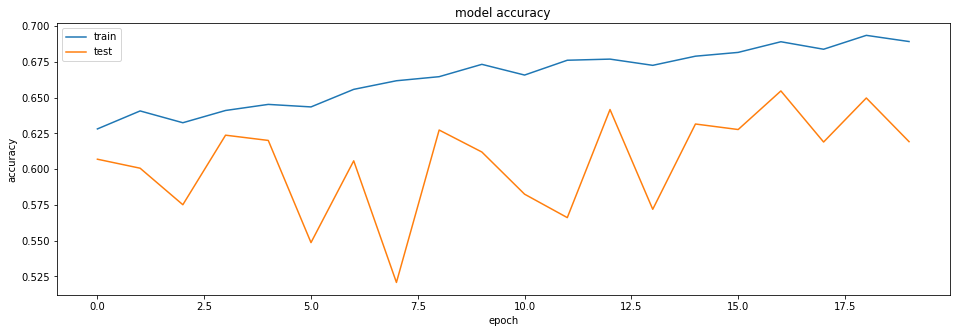

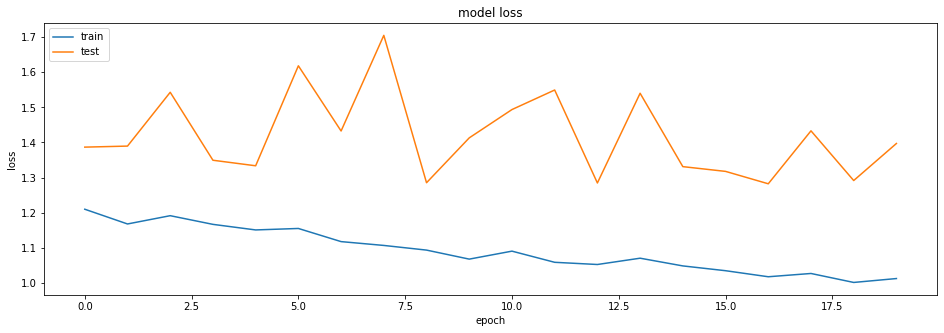

In [172]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history_root.history['accuracy'])
plt.plot(callback_history_root.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history_root.history['loss'])
plt.plot(callback_history_root.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Post Processing

Build function to transform Root-Bass-Quality -> To Chord

In [190]:
def Chordify(root = 'N', bass = 'null', quality = 'null'):
    if root == 'N': return root
    inverse = ''
    chord = root
    
    if quality[5] == 1 or quality[2] == 1 or quality[3] == 1 or quality[4] == 1 or quality[9] == 1:
        chord += ':'
    
    if quality[5] == 1:
        chord += 'min7'
    elif quality[2] == 1:
        chord += 'min'
        
    if quality[3] == 1:
        chord += '7'
    
    if quality[4] == 1:
        chord += 'maj7'
        
    if quality[9] == 1:
        chord += 'maj6'
    
    if bass != 'null':
        if root != bass:
            semitones = (12 - ChordLib[root]) - (12 - ChordLib[bass])
            if semitones < 0:
                semitones += 12
            if semitones != 0:
                if semitones == 2:
                    inverse = '/2'
                elif semitones == 3:
                    inverse = '/b3'
                elif semitones == 4:
                    inverse = '/3'
                elif semitones == 5:
                    inverse = '/4'
                elif semitones == 6:
                    inverse = '/b5'
                elif semitones == 7:
                    inverse = '/5'
                elif semitones == 8:
                    inverse = '/6'
                elif semitones == 9:
                    inverse = '/b7'
                elif semitones == 10:
                    inverse = '/7'
                elif semitones == 11:
                    inverse = '/#7'
            chord += inverse
    return chord

Sooth results by removing chords appearing for few frames ~= miliseconds

In [191]:
min_frames = 3

# estimated_chord_list
# estimated_quality_list

#pass through data
previous_seen_chord = estimated_chord_list[0]
previous_chord = estimated_chord_list[0]
appearances = 1
count = 1
for chord in estimated_chord_list[1:]:
    if previous_chord != chord:
        previous_chord = chord
        if appearances <= min_frames:
            for i in range(count-appearances, count):
                estimated_chord_list[i] = previous_seen_chord
        else:
            previous_seen_chord = chord
        #new chord -> appearances = 1
        appearances = 1
    else:    
        appearances += 1
                
    count += 1

chordlist = pd.Series(estimated_chord_list, name='Root', index=list(range(0, len(estimated_chord_list))))
df_predictions.update(chordlist)

estimated_quality_list = np.array(estimated_quality_list, dtype=int)

#pass through data
qualities = {tuple(df_predictions['Quality'][0]) : 1}
previous_chord = df_predictions['Root'][0]
count = 1
appearances = 1
for index, chord, quality in df_predictions[1:].itertuples():
    if previous_chord != chord:
        previous_chord = chord
        max_q = max(qualities, key=qualities.get)
        for i in range(count-appearances, count):
            estimated_quality_list[i] = np.array(max_q, dtype=int)
        qualities.clear()
        qualities = {tuple(quality) : 1}
        appearances = 1
    else:
        appearances += 1
        if tuple(quality) in qualities.keys():
            qualities[tuple(quality)] += 1
        else:
            qualities[tuple(quality)] = 1
    count += 1

qualitylist = pd.Series(estimated_quality_list.tolist(), name='Quality', index=list(range(0, len(estimated_quality_list.tolist()))))
df_predictions.update(qualitylist)

From #frames root/bass/Qualities transform into an annotation dataframe

In [192]:
#segments of audio data
segments = Timestamps['The Beatles'][album_test_track][test_track_no]

#annotation data
Annotation = {'Starts' : [], 'Ends' : [], 'Chord' : []}

#first chord
Annotation['Chord'].append(df_predictions['Root'][0])
Annotation['Starts'].append(0.0)

#rest of the predictions
step = 1
current_chord = df_predictions['Root'][0]
for time in segments:
    chord = df_predictions['Root'][step]
    quality = df_predictions['Quality'][step]
    if current_chord != chord:
        Annotation['Ends'].append(time)
        Annotation['Chord'].append(Chordify(root=chord, quality=quality))
        Annotation['Starts'].append(time)
        current_chord = chord
    step+=1
Annotation['Ends'].append(time)

In [193]:
Annotation_df = pd.DataFrame(data=Annotation)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Annotation_df)

,Starts,Ends,Chord
0,0.000000,0.371519,N
1,0.371519,4.179592,C:min
2,4.179592,8.637823,E:min
3,8.637823,11.052698,C:min
4,11.052698,18.483084,E:min
5,18.483084,18.575964,Eb:min
6,18.575964,18.947483,E:min
7,18.947483,19.133243,Eb:min
8,19.133243,19.597642,E:min
9,19.597642,20.433560,Eb:min


In [194]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Chordlab['The Beatles'][album_test_track][test_track_no])

,Starts,Ends,Chord
0,0.061934,0.445329,N
1,0.445329,3.915659,C
2,3.915659,7.414302,E:min
3,7.414302,10.866452,C
4,10.866452,14.318603,E:min
5,14.318603,19.642119,E:min
6,19.642119,22.303878,C
7,22.303878,23.210503,E:min
8,23.210503,27.513015,E:min
9,27.513015,28.406163,E:min/b7


## MIREX Metrics

In [195]:
# delete inversion tool for accuracy
def delete_inversion(chord):
    if chord.find('/') != -1:
        chord, _ = chord.split('/')
    return chord

In [196]:
times = Timestamps[Artist][album_test_track][test_track_no]
df_rows = Chordlab[Artist][album_test_track][test_track_no].itertuples()
index = 0
max_len = len(Chordlab[Artist][album_test_track][test_track_no])
segments_true_chords = []
row = next(df_rows)
for timestamp in times:
    if ((index + 1) < max_len) & (timestamp >= row[2]):
        index += 1
        row = next(df_rows)
    segments_true_chords.append(row[3])

In [197]:
#CSR
CSR = 0

#segments of audio data
segments = Timestamps[Artist][album_test_track][test_track_no]

#compute total time of correct estimations
step = 0
prev_timing = 0
total_time_of_correct_estimation = 0
for time in segments:
    true_chord = segments_true_chords[step]
    estimated_chord = Chordify(root=df_predictions['Root'][step], quality=df_predictions['Quality'][step])
    if (estimated_chord == delete_inversion(true_chord)):
        total_time_of_correct_estimation += time - prev_timing
    prev_timing = time
    step += 1

#total time of segments        
total_time_of_segments = Timestamps[Artist][album_test_track][test_track_no][-1]

#CSR
CSR = total_time_of_correct_estimation / total_time_of_segments
print ("Accuracy Achieved by MIREX metric CSR = % 3.3f %%" %(CSR*100))

Accuracy Achieved by MIREX metric CSR =  42.113 %
